In [23]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import torchvision
import torch

from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader
from resnet import DeviceDataLoader, ResNet9, evaluate, fit_one_cycle, get_default_device, to_device

IMAGE_SIZE = 32

In [2]:
import os

try:
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Set working directory
    os.chdir('/content/drive/My Drive/CSC 461/Final/')

    # Extract images from train.tar. Takes about 11 minutes.
    # Has to be done each time you restart the runtime unless you extract and upload
    # the files manually (which can take hours)
    !tar -xf train.tar --totals --checkpoint=.4000 --checkpoint-action='echo=Hit %s checkpoint #%u/79433'
except:
    # If it fails, we're probably running locally and don't need to extract the files
    pass

In [3]:
# Load the data
df = pd.read_csv('train_info.csv')

# Keep only the columns we need: filename and style
df = df[['filename', 'style']]

# Drop rows with blank styles
df = df.dropna()

# Drop rows with styles that have less than 1000 images
df = df[df['style'].map(df['style'].value_counts()) > 1000]

print('There are {} styles in the csv:'.format(df['style'].nunique()))
display(df['style'].value_counts())

There are 19 styles in the csv:


Impressionism                   8220
Realism                         8112
Romanticism                     7041
Expressionism                   5325
Post-Impressionism              4527
Art Nouveau (Modern)            3779
Baroque                         3254
Surrealism                      3133
Symbolism                       2626
Rococo                          2101
Northern Renaissance            1824
Naïve Art (Primitivism)         1776
Neoclassicism                   1622
Abstract Expressionism          1546
Cubism                          1316
Ukiyo-e                         1137
Early Renaissance               1052
High Renaissance                1050
Mannerism (Late Renaissance)    1025
Name: style, dtype: int64

In [4]:
# Helper functions for getting the files set up correctly
# Load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set the maximum number of pixels for an image to 100 billion
Image.MAX_IMAGE_PIXELS = 100000000000

def resize_images(directory, size):
    # Create transformer that:
    # 1. Resizes the image to have the largest dimension equal to size
    # 2. Converts the image to a JPEG if necessary

    # Get the list of images
    images = os.listdir(directory)

    # Resize the images
    for image in images:
        try:
            img = Image.open(os.path.join(directory, image))
            placeholder = torchvision.transforms.Resize((size, size))(img)

            # Check that image is JPEG
            if placeholder.mode != 'RGB':
                placeholder = placeholder.convert('RGB')

            placeholder.save(os.path.join(directory, image))
        except Exception as e:
            print(f'Failed to resize {image} because {e}')

def sort_images(df, test_size=0.2):
    # Create a folder for each class if it doesn't exist
    for style in df['style'].unique():
        if not os.path.exists(os.path.join('data', 'imagecnn', 'train', style)):
            os.makedirs(os.path.join('data', 'imagecnn', 'train', style))

        if not os.path.exists(os.path.join('data', 'imagecnn', 'test', style)):
            os.makedirs(os.path.join('data', 'imagecnn', 'test', style))

    # Move the images to their respective folders
    for row in df.itertuples():
        filename = row.filename
        style = row.style
        
        try:
            shutil.move(os.path.join('train', filename), os.path.join('data', 'imagecnn', 'train', style, filename))
        except FileNotFoundError:
            # If the file doesn't exist, it's probably already been moved
            pass

    # Move the test images to their respective folders from the train directory folders
    for style in df['style'].unique():
        # Get the list of files in the train directory
        files = os.listdir(os.path.join('data', 'imagecnn', 'train', style))

        # Split the files into train and test
        train, test = train_test_split(files, test_size=test_size)

        # Move the test files to the test directory
        for file in test:
            shutil.move(os.path.join('data', 'imagecnn', 'train', style, file), os.path.join('data', 'imagecnn', 'test', style, file))



# Check if train/ exists. This will typically hold the extracted, untransformed, unresized images
# If it does exist, this means we need to move the images to their respective folders
if os.path.exists('train/'):
    # Resize the images
    resize_images('train/', IMAGE_SIZE)

    # Sort the images
    sort_images(df)

    # Count the number of files remaining in the train folder
    remaining_files = len(os.listdir('train'))

    # Print the number of files remaining
    print(f'Removing {remaining_files} files remaining in train/')

    # Remove the train folder
    shutil.rmtree('train/')

In [7]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         torchvision.transforms.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         torchvision.transforms.ToTensor(), 
                         torchvision.transforms.Normalize(*stats,inplace=True)])
valid_tfms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats)])

# Create the datasets
train_ds = torchvision.datasets.ImageFolder(os.path.join('data', 'imagecnn', 'train'), transform=torchvision.transforms.ToTensor())
valid_ds = torchvision.datasets.ImageFolder(os.path.join('data', 'imagecnn', 'test'), transform=torchvision.transforms.ToTensor())

# Create data loaders for the train and validation sets
batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [8]:
# Show the number of images in each class
print('There are {} images in the training set:'.format(len(train_ds)))
print('There are {} images in the validation set:'.format(len(valid_ds)))

# Show the number of images in the training set
class_counts = pd.Series([s[1] for s in train_ds.samples]).value_counts()
class_counts = {train_ds.classes[i]: class_counts[i] for i in range(len(train_ds.classes))}

print(f'There are {len(train_ds.classes)} classes in the training set:')
display(class_counts)

# Show the number of images in the validation set
class_counts = pd.Series([s[1] for s in valid_ds.samples]).value_counts()
class_counts = {valid_ds.classes[i]: class_counts[i] for i in range(len(valid_ds.classes))}

print(f'There are {len(valid_ds.classes)} classes in the validation set:')
display(class_counts)

There are 17100 images in the training set:
There are 1900 images in the validation set:
There are 19 classes in the training set:


{'Abstract Expressionism': 900,
 'Art Nouveau (Modern)': 900,
 'Baroque': 900,
 'Cubism': 900,
 'Early Renaissance': 900,
 'Expressionism': 900,
 'High Renaissance': 900,
 'Impressionism': 900,
 'Mannerism (Late Renaissance)': 900,
 'Naïve Art (Primitivism)': 900,
 'Neoclassicism': 900,
 'Northern Renaissance': 900,
 'Post-Impressionism': 900,
 'Realism': 900,
 'Rococo': 900,
 'Romanticism': 900,
 'Surrealism': 900,
 'Symbolism': 900,
 'Ukiyo-e': 900}

There are 19 classes in the validation set:


{'Abstract Expressionism': 100,
 'Art Nouveau (Modern)': 100,
 'Baroque': 100,
 'Cubism': 100,
 'Early Renaissance': 100,
 'Expressionism': 100,
 'High Renaissance': 100,
 'Impressionism': 100,
 'Mannerism (Late Renaissance)': 100,
 'Naïve Art (Primitivism)': 100,
 'Neoclassicism': 100,
 'Northern Renaissance': 100,
 'Post-Impressionism': 100,
 'Realism': 100,
 'Rococo': 100,
 'Romanticism': 100,
 'Surrealism': 100,
 'Symbolism': 100,
 'Ukiyo-e': 100}

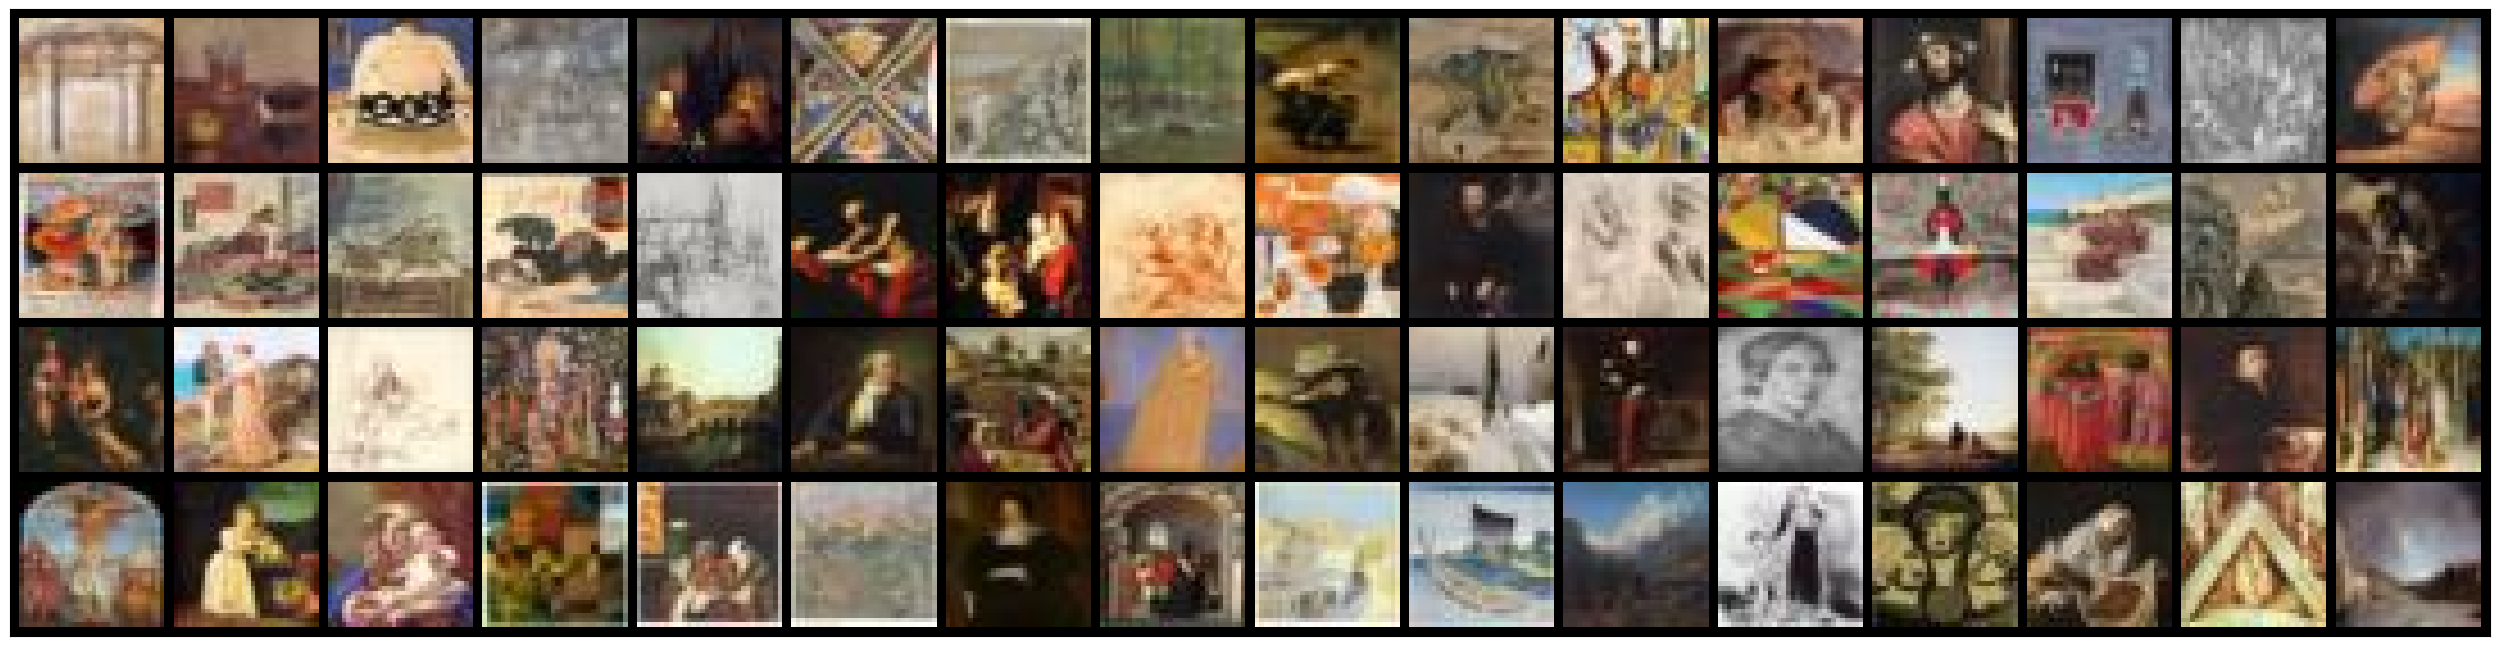

In [9]:
# Show a batch of images to make sure they are loaded correctly.
def show_batch(dl):
    for images, labels in dl:
        plt.subplots(figsize=(32, 32))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        plt.imshow(torchvision.utils.make_grid(images, nrow=int(2*batch_size ** 0.5)).permute(1, 2, 0))
        break

show_batch(train_dl)

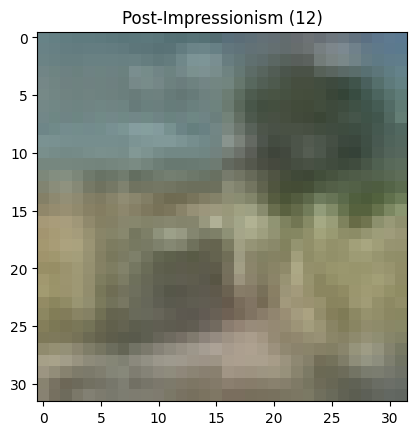

In [12]:
# Display a random image in higher resolution
def display_image(img, label):
    plt.title(f'{train_ds.classes[label]} ({label})')
    plt.imshow(img.permute(1, 2, 0))

display_image(*train_ds[np.random.randint(len(train_ds))])

In [13]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

device = get_default_device()
model = to_device(ResNet9(3, len(train_ds.classes)), device)

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [21]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.94525408744812, 'val_acc': 0.0520833320915699}]

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 2.9685, val_loss: 3.4278, val_acc: 0.1167


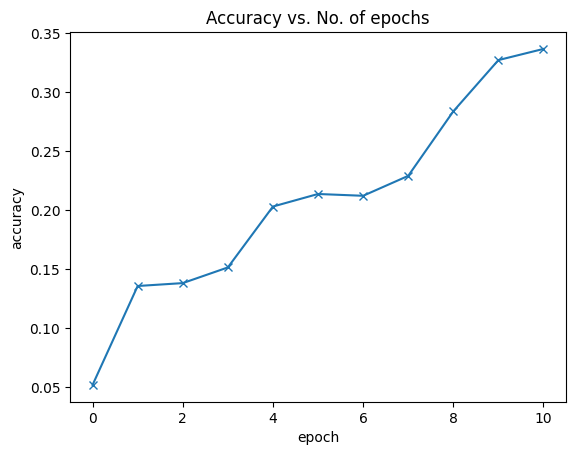

In [106]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

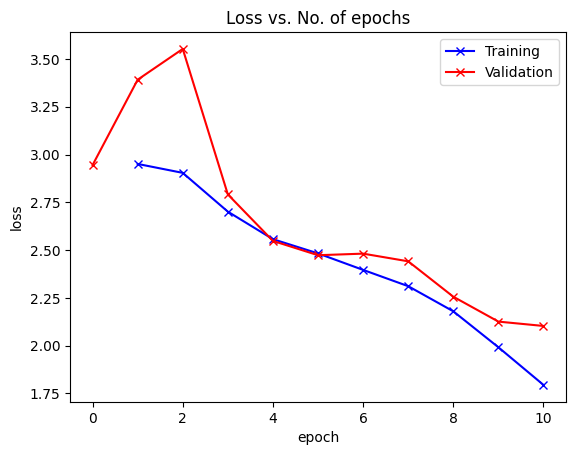

In [107]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [108]:
# Save model to the current directory
torch.save(model.state_dict(), 'artcnn.pth')


In [109]:
# Convert classes to a pandas dataframe
classes_df = pd.DataFrame(train_ds.classes, columns=['style'])

# Save the dataframe to a csv file
classes_df.to_csv('classes.csv', index=False, encoding='utf-8')

Label: Symbolism , Predicted: Symbolism


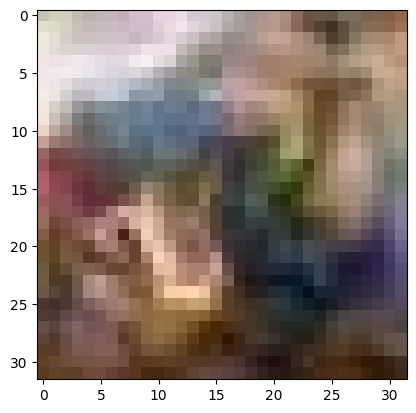

In [116]:
# Cell for class demo of the model
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)

    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

img, label = valid_ds[np.random.randint(0, len(valid_ds))]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

tensor([[3.0112]], grad_fn=<AddmmBackward0>)
Label: foo , Predicted: foo


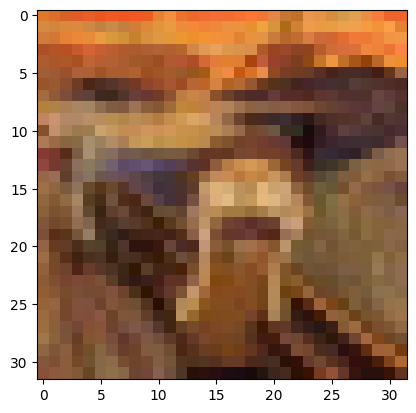

In [22]:
# Cell for class demo of the model
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    #print(xb)

    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

img, label = valid_ds[np.random.randint(0, len(valid_ds))]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))